In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [922]:
from scipy import stats

In [2]:
from geopy.geocoders import Nominatim
import json
import requests
from pandas.io.json import json_normalize

# import kmeans from clustering stage
from sklearn.cluster import KMeans
import folium

In [3]:
rent_df = pd.read_csv("toronto_rent_data.csv")
geo_coords = pd.read_csv("Geospatial_Coordinates.csv")

In [4]:
# make a copy of the df for testing codes
scraped_df = rent_df

In [5]:
rent_df.head()

,Rent,Address,Zip,num_bedrooms,num_bathrooms,num_sqft
0,"$3,300",85 Wood Street,M4Y,3,2,810
1,"$2,295",300 Balliol Street,M4S,1,1,600
2,"$2,300",8 Fieldway Road,M8Z,1,1,NaN
3,"$1,950",160 Flemington Road,M6A,2,2,630
4,"$2,045",117 Gerrard Street East,M5B,1,1,NaN


In [6]:
geo_coords.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [7]:
# check for null values 
rent_df.isnull().sum()
# missing 5 zip codes and 945 sqft of units

Rent               0
Address            0
Zip                5
num_bedrooms       0
num_bathrooms      0
num_sqft         945
dtype: int64

In [8]:
# check data type for each features
rent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2450 entries, 0 to 2449
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Rent           2450 non-null   object
 1   Address        2450 non-null   object
 2   Zip            2445 non-null   object
 3   num_bedrooms   2450 non-null   object
 4   num_bathrooms  2450 non-null   object
 5   num_sqft       1505 non-null   object
dtypes: object(6)
memory usage: 115.0+ KB


### Convert Datatypes (Data Cleaning)

In [9]:
scraped_df['Rent'][0].replace("$","").replace(",","")
# scraped_df['Rent'][0].replace(",","")

'3300'

In [10]:
# delete the dollar sign and comma before turning to float
for i in range(len(rent_df['Rent'])):
    rent_df["Rent"][i] = rent_df["Rent"][i].replace("$", "").replace(",", "")


In [11]:
rent_df.head()

,Rent,Address,Zip,num_bedrooms,num_bathrooms,num_sqft
0,3300,85 Wood Street,M4Y,3,2,810
1,2295,300 Balliol Street,M4S,1,1,600
2,2300,8 Fieldway Road,M8Z,1,1,NaN
3,1950,160 Flemington Road,M6A,2,2,630
4,2045,117 Gerrard Street East,M5B,1,1,NaN


In [12]:
rent_df.iloc[0,:]

Rent                       3300
Address          85 Wood Street
Zip                         M4Y
num_bedrooms                  3
num_bathrooms                 2
num_sqft                    810
Name: 0, dtype: object

In [13]:
# create empty dataframe to store ranged data
empty_ranged_df = pd.DataFrame(columns = rent_df.columns)

# append all values in the dataset that have the "-" in cells
for features in rent_df.columns:
#     print(features)
    empty_ranged_df = pd.concat([empty_ranged_df, (rent_df[rent_df[features].astype(str).str.contains("-")])])

In [14]:
# dislay all data
# pd.set_option("display.max_rows",None)

In [15]:
empty_ranged_df

,Rent,Address,Zip,num_bedrooms,num_bathrooms,num_sqft
191,1750 - 2000,7895 Jane Street,L4K,1 - 2,1 - 2,500-800
438,2200 - 2300,77 Shuter Street,M5B,1,1 ½,550-650
476,1750 - 2050,38 Cameron Street,M5T,1,1 - 1 ½,521-654
480,1895 - 3875,1 Edgewater Drive,M5A,1 - 2,1 - 2 ½,466-1119
563,1950 - 2850,16 Yonge Street,M5E,1 - 2,1 - 2,478-815
...,...,...,...,...,...,...
1535,1680 - 2000,1030 King Street West,M6K,0 - 1,1,370-450
1704,1700 - 4200,50 John Street,M5V,0 - 2,1 - 2,365-1230
2167,1850 - 2250,60 Ann OReilly Road,M2J,1 - 2,1 - 2,580-828
2372,1850 - 2400,7 Mabelle Avenue,M9A,1 - 2,1 - 2,488-779


In [16]:
empty_ranged_df.shape

(106, 6)

In [17]:
empty_ranged_df.index

Int64Index([ 191,  438,  476,  480,  563,  566,  589,  608,  732,  773,
            ...
            1105, 1138, 1196, 1418, 1480, 1535, 1704, 2167, 2372, 2398],
           dtype='int64', length=106)

In [18]:
# delete duplicate indexes
empty_ranged_df.index.drop_duplicates(keep='first')

Int64Index([ 191,  438,  476,  480,  563,  566,  589,  608,  732,  773,  825,
             830,  836,  890,  962, 1041, 1043, 1071, 1090, 1105, 1138, 1196,
            1418, 1480, 1535, 1635, 1642, 1704, 2167, 2321, 2365, 2372, 2398,
             186, 1045,  692],
           dtype='int64')

In [19]:
empty_ranged_df = empty_ranged_df.loc[~empty_ranged_df.index.duplicated(keep="first")]

In [20]:
# check if changes are made
empty_ranged_df.shape

(36, 6)

In [21]:
empty_ranged_df.head()

,Rent,Address,Zip,num_bedrooms,num_bathrooms,num_sqft
191,1750 - 2000,7895 Jane Street,L4K,1 - 2,1 - 2,500-800
438,2200 - 2300,77 Shuter Street,M5B,1,1 ½,550-650
476,1750 - 2050,38 Cameron Street,M5T,1,1 - 1 ½,521-654
480,1895 - 3875,1 Edgewater Drive,M5A,1 - 2,1 - 2 ½,466-1119
563,1950 - 2850,16 Yonge Street,M5E,1 - 2,1 - 2,478-815


In [22]:
# select only data that don't contain range of values
rent_norange_df = rent_df[rent_df.index.isin(empty_ranged_df.index) == False]

In [23]:
# rent_norange_df should have 2414 rows because 2450 - 36 = 2414
rent_norange_df.shape

(2414, 6)

In [24]:
rent_df.shape

(2450, 6)

In [25]:
rent_norange_df['num_bedrooms'].unique()
rent_norange_df['num_bathrooms'].unique()


array(['2', '1', '1 ½', '3', '0 ½', '0', '2 ½'], dtype=object)

In [26]:
rent_norange_df['num_bathrooms'][0].replace("½",".5").replace(" ","")

'2'

In [27]:
rent_norange_df.head(3)

,Rent,Address,Zip,num_bedrooms,num_bathrooms,num_sqft
0,3300,85 Wood Street,M4Y,3,2,810
1,2295,300 Balliol Street,M4S,1,1,600
2,2300,8 Fieldway Road,M8Z,1,1,NaN


In [28]:
# reset index before looping through the changes
rent_norange_df = rent_norange_df.reset_index(drop=True)

In [29]:
rent_norange_df.loc[[185,186,187,188,189,190]]

,Rent,Address,Zip,num_bedrooms,num_bathrooms,num_sqft
185,1900,2916 Highway 7,L4K,1,0 ½,550
186,2300,2908 Highway 7,L4K,2,2,800899
187,2000,2916 Highway 7,L4K,1,1 ½,630
188,2000,7895 Jane Street,L4K,1,2,611
189,2200,7895 Jane Street,L4K,2,2,750
190,2250,7895 Jane Street,L4K,2,2,649


In [30]:
# change "1/2" into 0.5
for bath in range(rent_norange_df.shape[0]):
    rent_norange_df['num_bathrooms'][bath] = rent_norange_df['num_bathrooms'][bath].replace("½",".5").replace(" ","")

In [31]:
# check if changes are made
rent_norange_df['num_bathrooms'].unique()

array(['2', '1', '1.5', '3', '0.5', '0', '2.5'], dtype=object)

In [32]:
rent_norange_df.dtypes

Rent             object
Address          object
Zip              object
num_bedrooms     object
num_bathrooms    object
num_sqft         object
dtype: object

In [33]:
# convert datatypes
rent_norange_df["Rent"] = rent_norange_df["Rent"].astype(float)
rent_norange_df["num_bedrooms"] = rent_norange_df["num_bedrooms"].astype(float)
rent_norange_df["num_bathrooms"] = rent_norange_df["num_bathrooms"].astype(float)
rent_norange_df["num_sqft"] = rent_norange_df["num_sqft"].astype(float)


In [34]:
rent_norange_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2414 entries, 0 to 2413
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rent           2414 non-null   float64
 1   Address        2414 non-null   object 
 2   Zip            2410 non-null   object 
 3   num_bedrooms   2414 non-null   float64
 4   num_bathrooms  2414 non-null   float64
 5   num_sqft       1472 non-null   float64
dtypes: float64(4), object(2)
memory usage: 113.3+ KB


In [35]:
# match the postal codes
# check the number of postal codes that match
rent_df.loc[rent_df['Zip'].isin(geo_coords['Postal Code']), :].shape

(2300, 6)

In [36]:
# check for null values
rent_norange_df.isnull().sum()

Rent               0
Address            0
Zip                4
num_bedrooms       0
num_bathrooms      0
num_sqft         942
dtype: int64

Just going to drop all the null values because 942 null values is too much for this dataset (represents 1/3 of the data for num_sqft) and there's not point in keeping data that doesn't have a zip code because the whole point of this analysis is plot all the data on a map.

In [37]:
rent_norange_df.shape

(2414, 6)

In [38]:
# find the rows that contain null values for "Zip"
rent_norange_df.loc[rent_norange_df['Zip'].isnull()]

,Rent,Address,Zip,num_bedrooms,num_bathrooms,num_sqft
13,2080.0,35 Balmuto Street,NaN,1.0,1.0,610.0
93,1900.0,3560 St Clair Ave E | Unit: 418,NaN,1.0,1.0,700.0
1990,2500.0,50 Ann O'Reilly Road | Unit: 2,NaN,2.0,2.0,1075.0
2014,2950.0,85 The Donway W,NaN,2.0,2.0,1450.0


In [39]:
# remove null values
dropped_nulls_df = rent_norange_df.dropna()
one_bedroom_df = rent_norange_df.loc[rent_norange_df['num_bedrooms'] == 1].dropna()

In [40]:
dropped_nulls_df.shape
one_bedroom_df.shape

(934, 6)

In [41]:
dropped_nulls_df.loc[dropped_nulls_df['Zip'].isin(geo_coords["Postal Code"])].shape

(1342, 6)

In [42]:
dropped_nulls_df = dropped_nulls_df.reset_index(drop=True)
one_bedroom_df = one_bedroom_df.reset_index(drop=True)


#### Store Data into a database

In [43]:
from sqlalchemy import create_engine

In [44]:
connection_string = "postgres:postgres@localhost:5432/toronto-rental-properties"
engine = create_engine(f'postgresql://{connection_string}')

In [45]:
connection = engine.connect()

In [46]:
dropped_nulls_df.to_sql(name="all_data", con = engine, if_exists="replace",index = False)

In [47]:
# change column names for geo_coords before storing in pgadmin
geo_coords.rename(columns = ({"Postal Code": "postal_code"}), inplace = True)

In [48]:
geo_coords_columnNames = ['postal_code', "latitude", "longitude"]

In [49]:
geo_coords.columns = geo_coords_columnNames

In [50]:
one_bedroom_columnNames = ['rent', 'address', 'zip', 'num_bedrooms', 'num_bathrooms', 'num_sqft']

In [51]:
one_bedroom_df.columns = one_bedroom_columnNames

In [52]:
one_bedroom_df.head(4)

,rent,address,zip,num_bedrooms,num_bathrooms,num_sqft
0,2295.0,300 Balliol Street,M4S,1.0,1.0,600.0
1,2050.0,83 Redpath Avenue,M4S,1.0,1.0,562.0
2,2350.0,633 Bay Street,M5G,1.0,1.5,833.0
3,2250.0,88 Harbour Street,M5J,1.0,1.0,581.0


In [53]:
one_bedroom_df.to_sql(name="one_bedroom_data", con = engine, if_exists = "replace", index=False)


In [54]:
geo_coords.to_sql(name="geo_data", con = engine, if_exists = "replace", index = False)

In [74]:
pd.read_sql_query("SELECT * \
                    FROM one_bedroom_data \
                    LIMIT 5", connection)

,rent,address,zip,num_bedrooms,num_bathrooms,num_sqft
0,2295.0,300 Balliol Street,M4S,1.0,1.0,600.0
1,2050.0,83 Redpath Avenue,M4S,1.0,1.0,562.0
2,2350.0,633 Bay Street,M5G,1.0,1.5,833.0
3,2250.0,88 Harbour Street,M5J,1.0,1.0,581.0
4,1950.0,66 Portland Street,M5V,1.0,1.0,570.0


In [129]:
# join datasets with sql to flex my sql skills
sql_merged = pd.read_sql_query("SELECT g.postal_code,\
                               g.latitude,\
                               g.longitude,\
                               ob.rent,\
                               ob.address,\
                               ob.num_bedrooms,\
                               ob.num_bathrooms,\
                               ob.num_sqft\
                               FROM geo_data g\
                               JOIN one_bedroom_data ob\
                               ON ob.zip = g.postal_code", connection)

In [130]:
sql_merged.loc[sql_merged['postal_code'] == "M5V"].sort_values(by='num_sqft')

,postal_code,latitude,longitude,rent,address,num_bedrooms,num_bathrooms,num_sqft
591,M5V,43.628947,-79.39442,1850.0,215 Queen Street West,1.0,1.0,400.0
548,M5V,43.628947,-79.39442,2200.0,290 Adelaide Street West,1.0,1.0,400.0
675,M5V,43.628947,-79.39442,2000.0,Stewart Street,1.0,1.0,420.0
579,M5V,43.628947,-79.39442,2090.0,629 King Street West,1.0,1.0,450.0
718,M5V,43.628947,-79.39442,2200.0,88 Blue Jays Way,1.0,1.0,450.0
...,...,...,...,...,...,...,...,...
706,M5V,43.628947,-79.39442,3000.0,156 Portland Street,1.0,1.0,780.0
549,M5V,43.628947,-79.39442,2500.0,19 Brant Street,1.0,1.0,806.0
619,M5V,43.628947,-79.39442,2600.0,833 King Street West,1.0,1.0,820.0
716,M5V,43.628947,-79.39442,2600.0,550 Queens Quay West,1.0,1.5,830.0


In [607]:
from geopy.extra.rate_limiter import RateLimiter

In [892]:
# Nominatim(user_agent="myGeocoder").geocode("19 Brant Street, Toronto")
locator = Nominatim(user_agent = "myGeocoder")
geocode = RateLimiter(locator.geocode,min_delay_seconds=1)
location = locator.geocode(sql_merged['address'][100])

In [897]:
location.address

'23-33, Sheppard Avenue East, Lansing, North York, Toronto, Golden Horseshoe, Ontario, M2N 5W9, Canada'

In [615]:
# check for null values
sql_merged.isnull().sum()

postal_code      0
latitude         0
longitude        0
rent             0
address          0
num_bedrooms     0
num_bathrooms    0
num_sqft         0
dtype: int64

In [619]:
sql_merged['address'] = sql_merged['address'] + ", Toronto"

In [871]:
sql_merged.loc[sql_merged['address'].str.contains("Sonic")].head()

,postal_code,latitude,longitude,rent,address,num_bedrooms,num_bathrooms,num_sqft
126,M3C,43.7259,-79.340923,1850.0,"Sonic Way, Toronto",1.0,2.0,650.0
128,M3C,43.7259,-79.340923,1850.0,"Sonic Way, Toronto",1.0,2.0,650.0
129,M3C,43.7259,-79.340923,1850.0,"Sonic Way, Toronto",1.0,2.0,650.0
130,M3C,43.7259,-79.340923,1870.0,"Sonic Way, Toronto",1.0,2.0,650.0
131,M3C,43.7259,-79.340923,1900.0,"2 Sonic Way, Toronto",1.0,2.0,650.0


In [687]:
# change address formatting
sql_merged['address'][96] = "621 Sheppard Ave E, Toronto"
sql_merged['address'][103] = "23 Sheppard Ave E , Toronto"
sql_merged['address'][109] = "5180 Yonge St, Toronto"
sql_merged['address'][232] = "942 Yonge St, Toronto"
sql_merged['address'][341] = "464 Adelaide St E, Toronto"
sql_merged['address'][511] = "155 Yorkville Ave, Toronto"
sql_merged['address'][567] = "101 Peter St, Toronto"
sql_merged['address'][615] = "88 Blue Jays Way, Toronto"
sql_merged['address'][679] = "35 Mariner Terrace, Toronto"
sql_merged['address'][757] = "150 Sudbury St, Toronto"

C:\Users\smartestpersonalive\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\smartestpersonalive\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\smartestpersonalive\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This i

In [824]:
sql_merged.iloc[131]

postal_code                       M3C
latitude                      43.7259
longitude                    -79.3409
rent                             1900
address          2 Sonic Way, Toronto
num_bedrooms                        1
num_bathrooms                       2
num_sqft                          650
Name: 131, dtype: object

In [821]:
geocode_latitude_list2 = []
geocode_longitude_list2 = []

In [869]:
len(geocode_latitude_list2)

860

In [868]:
# sql_merged.shape[0]
for merge in range(len(geocode_latitude_list2), sql_merged.shape[0]):
    clear_output(wait=True)
    try:
        geocode = RateLimiter(locator.geocode,min_delay_seconds=0.5)
        somewhereInToronto = locator.geocode(sql_merged['address'][merge])
        if somewhereInToronto != None:            
            geocode_latitude_list2.append(somewhereInToronto.latitude)
            geocode_longitude_list2.append(somewhereInToronto.longitude)
        elif somewhereInToronto == None:
            geocode_latitude_list2.append(np.nan)
            geocode_longitude_list2.append(np.nan)

        print(f"Current Progress: {np.round((merge+1)/sql_merged.shape[0] * 100,2)}%")
    
    except "GeocoderTimedOut":
        print("another time out")

    


Current Progress: 100.0%


In [872]:
sql_merged['geocode_lat'] = geocode_latitude_list2
sql_merged['geocide_lng'] = geocode_longitude_list2

In [880]:
one_bedroom_geocoded = sql_merged.loc[:, sql_merged.columns[[0] + list(range(3,sql_merged.shape[1]))]]

In [881]:
# reorder the columns
["postal_code", "geocode_lat","geocide_lng", "address", "num_sqft", "num_bedrooms", "num_bathrooms", "rent"]

Index(['postal_code', 'rent', 'address', 'num_bedrooms', 'num_bathrooms',
       'num_sqft', 'geocode_lat', 'geocide_lng'],
      dtype='object')

In [905]:
one_bedroom_geocoded = one_bedroom_geocoded.loc[:, one_bedroom_geocoded.columns[[0,2,-2,-1] + list(range(3,6)) + [1]]]
one_bedroom_geocoded.head(2)

,postal_code,geocode_lat,num_sqft,rent,geocide_lng,num_bedrooms,num_bathrooms,address
0,M1H,43.781624,750.0,1925.0,-79.247376,1.0,1.0,"36 Lee Centre Drive, Toronto"
1,M1H,43.781660,650.0,1950.0,-79.247547,1.0,1.0,"38 Lee Centre Drive, Toronto"


### Segment with the Foursquare API

In [915]:
one_bedroom_geocoded.describe()

,geocode_lat,num_sqft,rent,geocide_lng,num_bedrooms,num_bathrooms
count,836.000000,860.000000,860.000000,836.000000,860.0,860.000000
mean,43.674619,607.995349,2120.196512,-79.385789,1.0,1.078488
std,0.048027,116.763704,361.276752,0.053092,0.0,0.294403
min,43.597928,65.000000,1000.000000,-79.563108,1.0,0.000000
25%,43.641898,535.000000,1900.000000,-79.401150,1.0,1.000000
50%,43.652421,600.000000,2100.000000,-79.389737,1.0,1.000000
75%,43.701295,650.000000,2276.250000,-79.375726,1.0,1.000000
max,43.826271,2100.000000,8495.000000,-79.199573,1.0,3.000000


In [914]:
one_bedroom_geocoded.isnull().sum()

postal_code       0
geocode_lat      24
num_sqft          0
rent              0
geocide_lng      24
num_bedrooms      0
num_bathrooms     0
address           0
dtype: int64

In [918]:
# delete datapoints that don't have location data
one_bedroom_geocoded = one_bedroom_geocoded.dropna()

In [936]:
one_bedroom_geocoded = one_bedroom_geocoded.reset_index(drop=True)

In [920]:
one_bedroom_geocoded.isnull().sum()

postal_code      0
geocode_lat      0
num_sqft         0
rent             0
geocide_lng      0
num_bedrooms     0
num_bathrooms    0
address          0
dtype: int64

In [945]:
# add a price/sqft feature
one_bedroom_geocoded['price_per_sqft'] = one_bedroom_geocoded['rent'] / one_bedroom_geocoded['num_sqft']

In [946]:
one_bedroom_geocoded.head()

,postal_code,geocode_lat,num_sqft,rent,geocide_lng,num_bedrooms,num_bathrooms,address,price_per_sqft
0,M1H,43.781624,750.0,1925.0,-79.247376,1.0,1.0,"36 Lee Centre Drive, Toronto",2.566667
1,M1H,43.781660,650.0,1950.0,-79.247547,1.0,1.0,"38 Lee Centre Drive, Toronto",3.000000
2,M1H,43.781661,650.0,1950.0,-79.245271,1.0,1.0,"11 Lee Centre Drive, Toronto",3.000000
3,M1H,43.780832,650.0,1850.0,-79.247346,1.0,1.0,"8 Lee Centre Drive, Toronto",2.846154
4,M1H,43.773869,650.0,2000.0,-79.249988,1.0,1.0,"88 Grangeway Avenue, Toronto",3.076923


Determine outliers for the pirce/sqft

* z-score

* IQR

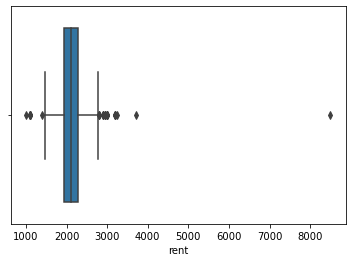

In [937]:
# Determine Outliers
sns.boxplot(x=one_bedroom_geocoded['rent'])

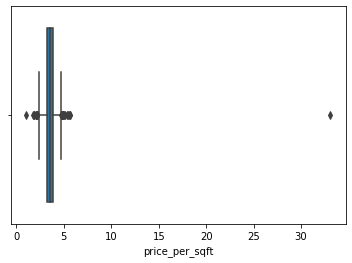

In [963]:
sns.boxplot(x=one_bedroom_geocoded['price_per_sqft'])

In [964]:
z = np.abs(stats.zscore(one_bedroom_geocoded['price_per_sqft']))

In [991]:
threshold = 3
print(np.where(z>=3))


(array([77], dtype=int64),)


In [993]:
def zscorefunc(num):
    if num >=3:
        return num

In [999]:
# obtain the absolute values of all z-scores
one_bedroom_geocoded[abs(stats.zscore(one_bedroom_geocoded['price_per_sqft']))>=3]

,postal_code,geocode_lat,num_sqft,rent,geocide_lng,num_bedrooms,num_bathrooms,address,price_per_sqft
77,M2K,43.766739,65.0,2150.0,-79.385882,1.0,2.0,"7 Kenaston Gardens, Toronto",33.076923


In [998]:
one_bedroom_geocoded = one_bedroom_geocoded.reset_index(drop=True)

In [1005]:
# remove outlier
one_bedroom_geocoded.drop(one_bedroom_geocoded.index[77], inplace=True)

In [1006]:
one_bedroom_geocoded.iloc[77]

postal_code                          M2K
geocode_lat                      43.7677
num_sqft                             680
rent                                1845
geocide_lng                     -79.3829
num_bedrooms                           1
num_bathrooms                          1
address           27 Rean Drive, Toronto
price_per_sqft                   2.71324
Name: 78, dtype: object

In [1002]:
# using IQR to determine outliers
Q1 = one_bedroom_geocoded['price_per_sqft'].quantile(0.25)
Q3 = one_bedroom_geocoded['price_per_sqft'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

0.6027947579556159


In [1003]:
one_bedroom_geocoded.loc[(one_bedroom_geocoded['price_per_sqft'] < (Q1 - 1.5*IQR)) |\
                        (one_bedroom_geocoded['price_per_sqft'] > (Q3 + 1.5*IQR))]

,postal_code,geocode_lat,num_sqft,rent,geocide_lng,num_bedrooms,num_bathrooms,address,price_per_sqft
24,M1P,43.769474,899.0,1700.0,-79.283399,1.0,1.0,"2 Glamorgan Avenue, Toronto",1.890990
77,M2K,43.766739,65.0,2150.0,-79.385882,1.0,2.0,"7 Kenaston Gardens, Toronto",33.076923
131,M3C,43.711432,780.0,1690.0,-79.333335,1.0,1.0,"725 Don Mills Road, Toronto",2.166667
208,M4S,43.700275,2100.0,2100.0,-79.396471,1.0,2.0,"1 Belsize Drive, Toronto",1.000000
299,M5A,43.645093,334.0,1695.0,-79.368274,1.0,1.0,"Richardson Street, Toronto",5.074850
357,M5B,43.655031,380.0,1800.0,-79.375478,1.0,1.0,"77 Shuter Street, Toronto",4.736842
363,M5B,43.653252,400.0,1970.0,-79.379481,1.0,1.0,"197 Yonge St, Toronto",4.925000
386,M5E,43.649568,475.0,2350.0,-79.375667,1.0,1.0,"22 Leader Lane, Toronto",4.947368
404,M5G,43.659419,500.0,2400.0,-79.384967,1.0,1.0,"761 Bay Street, Toronto",4.800000
412,M5G,43.659694,885.0,1500.0,-79.385928,1.0,1.0,"750 Bay Street, Toronto",1.694915


In [1012]:
# reorder the columns
one_bedroom_geocoded.columns = ["postal_code", "geocode_lat","num_sqft", "rent", "geocide_lng", "num_bedrooms",\
                                "num_bathrooms", "address", "price_per_sqft"]

In [1041]:
# reorder the columns
one_bedroom_geocoded = one_bedroom_geocoded[['postal_code', 'geocode_lat', 'geocode_lng', 'address',\
                                             'num_sqft', 'rent', 'num_bathrooms', 'price_per_sqft']]

In [ ]:
one_bedroom_geocoded = one_bedroom_geocoded.reset_index(drop=True)

In [1298]:
url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}".\
    format("XBC43DIA4JU4HWR15RTGQJA1U3APK22VQ2FAM14WFAN3ODTK", "4ZI1MPZOVK2QF5QVO4BYDGQ5TAFZ0TFCKBKQTX3PK0JIJ1AI", version, lat, lng, categoryid, 10000, 5)

results = requests.get(url).json()
#     ['response']['groups'][0]['items'][0]
results
#     venues = [results['venue']['id'],
#            results['venue']['name'],
#            [(cat['name'], cat['id']) for cat in results['venue']['categories']],
#            [results['venue']['location']['lat'], results['venue']['location']['lng']],
#            [",".join(results['venue']['location']['formattedAddress'])], 
#            results['venue']['location']['distance']] 

{'meta': {'code': 200, 'requestId': '5f1b8873531fe866007ae403'},
 'response': {'headerLocation': 'Toronto',
  'headerFullLocation': 'Toronto',
  'headerLocationGranularity': 'city',
  'query': 'shopping plaza',
  'totalResults': 9,
  'suggestedBounds': {'ne': {'lat': 43.729969990000086,
    'lng': -79.25713613699601},
   'sw': {'lat': 43.54996980999991, 'lng': -79.505397063004}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5df2353480f315000705a80b',
       'name': 'Calyx Wellness Yorkville',
       'location': {'address': '124 Cumberland St',
        'lat': 43.65398990173588,
        'lng': -79.38779175281525,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65398990173588,
          'lng': -79.38779175281525}],
        'distance': 1646,
        'p

In [1267]:
# define a function for getting location data:
def get_venues(client_id, client_secret, version, lat, lng, categoryid, radius, limit):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}".\
        format(client_id, client_secret, version, lat, lng, categoryid, radius, limit)
#     try:
    results = requests.get(url).json()['response']['groups'][0]['items'][0]

    venues = [results['venue']['id'],
           results['venue']['name'],
           [(cat['name'], cat['id']) for cat in results['venue']['categories']],
           [results['venue']['location']['lat'], results['venue']['location']['lng']],
           [",".join(results['venue']['location']['formattedAddress'])], 
           results['venue']['location']['distance']] 
#     except:
#         venues = ["none in the specified radius","none in the specified radius",\
#                "none in the specified radius","none in the specified radius",\
#                "none in the specified radius","none in the specified radius"]
    
    return venues
    
    


In [1334]:
loop_counter = 0

In [1335]:

start = timeit.default_timer()

if "addon_df" in globals():
    del addon_df
if "complete_df" in globals():
    del complete_df


for postal, lat, lng, ind in zip(one_bedroom_geocoded['postal_code'][456:],\
                            one_bedroom_geocoded['geocode_lat'][456:],\
                            one_bedroom_geocoded['geocode_lng'][456:],\
                            one_bedroom_geocoded.index.values[456:]):
    
    clear_output(wait=True)
    
    venue_id = []
    venue_name = []
    venue_categories = []
    venue_latlng = []
    venue_address = []
    venue_distance = []
    for cat in categories_df['categoryids']:
        venues = get_venues("XBC43DIA4JU4HWR15RTGQJA1U3APK22VQ2FAM14WFAN3ODTK", "4ZI1MPZOVK2QF5QVO4BYDGQ5TAFZ0TFCKBKQTX3PK0JIJ1AI", version, lat, lng, cat, 25000, 3)
        venue_id = venue_id + [venues[0]]
        venue_name = venue_name + [venues[1]]
        venue_categories = venue_categories + [venues[2]]
        venue_latlng = venue_latlng + [venues[3]]
        venue_address = venue_address + [venues[4]]
        venue_distance = venue_distance + [venues[5]]
            
#     num = one_bedroom_geocoded.index[one_bedroom_geocoded['postal_code'] == postal].values[0]
    
    try:
        location_loop = one_bedroom_geocoded.iloc[[ind]].T
    except:
        print("data collection complete")

    if ind != 456:
        addon_df = location_loop.append(pd.DataFrame([venue_distance[0],\
                  venue_distance[1],\
                  venue_distance[2],\
                  venue_distance[3],\
                  venue_distance[4],\
                  venue_distance[5],\
                  venue_distance[6]], index = ["metro_station",\
                                              "train_station",\
                                              "bus_station",\
                                              "bus_stop",\
                                              "shopping_mall",\
                                              "shopping_plaza",\
                                              "grocery_store"], columns=[ind]))
    else:
           complete_df = location_loop.append(pd.DataFrame([venue_distance[0],\
                  venue_distance[1],\
                  venue_distance[2],\
                  venue_distance[3],\
                  venue_distance[4],\
                  venue_distance[5],\
                  venue_distance[6]], index = ["metro_station",\
                                              "train_station",\
                                              "bus_station",\
                                              "bus_stop",\
                                              "shopping_mall",\
                                              "shopping_plaza",\
                                              "grocery_store"], columns=[ind]))

    

    try:
        complete_df = pd.concat([complete_df, addon_df], axis=1)

    except:
        print("first one finished")
        
#     loop_counter +=1
#     if loop_counter == 2:
#         break
    
    stop = timeit.default_timer()
    print(f"Current Progress: {np.round(((ind+1)/one_bedroom_geocoded.shape[0]) * 100, 2)}%")
    print(f"Current run time: {np.round((stop - start)/60, 2)} minutes")

Current Progress: 100.0%
Current run time: 20.41 minutes


In [1329]:
complete_df3.head()

,116,117,118,119,120,121,122,123,124,125,...,446,447,448,449,450,451,452,453,454,455
postal_code,M2N,M2N,M2N,M2N,M2N,M2N,M3A,M3B,M3C,M3C,...,M5J,M5J,M5J,M5J,M5J,M5J,M5J,M5J,M5J,M5J
geocode_lat,43.7607,43.7783,43.7749,43.7785,43.7607,43.7783,43.7628,43.7377,43.7299,43.6508,...,43.6426,43.6404,43.6421,43.6419,43.6415,43.6415,43.6423,43.6423,43.6426,43.6423
geocode_lng,-79.4087,-79.4154,-79.4139,-79.4132,-79.4087,-79.4154,-79.3454,-79.3457,-79.3273,-79.3969,...,-79.3772,-79.3807,-79.3836,-79.3757,-79.3833,-79.3833,-79.3808,-79.3808,-79.3772,-79.3808
address,"23 Sheppard Avenue East, Toronto","5508 Yonge Street, Toronto","5 Northtown Way, Toronto","18 Holmes Avenue, Toronto","23 Sheppard Avenue East, Toronto","5508 Yonge Street, Toronto","18 Graydon Hall Drive, Toronto","205 The Donway West, Toronto","5 Concorde Place, Toronto","Sonic Way, Toronto",...,"33 Bay Street, Toronto","8 York Street, Toronto","51 Lower Simcoe Street, Toronto","10 Queens Quay West, Toronto","25 Lower Simcoe Street, Toronto","25 Lower Simcoe Street, Toronto","55 Bremner Boulevard, Toronto","55 Bremner Boulevard, Toronto","33 Bay Street, Toronto","55 Bremner Boulevard, Toronto"
num_sqft,559,570,600,643,600,500,550,580,655,650,...,530,715,650,750,650,575,650,650,600,595


In [1328]:
complete_df2.head()

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,114,115
postal_code,M1H,M1H,M1H,M1H,M1H,M1H,M1H,M1H,M1H,M1H,...,M2N,M2N,M2N,M2N,M2N,M2N,M2N,M2N,M2N,M2N
geocode_lat,43.7816,43.7817,43.7817,43.7808,43.7739,43.7817,43.7816,43.781,43.7809,43.7803,...,43.7601,43.7576,43.7702,43.7785,43.758,43.7681,43.7688,43.7614,43.7688,43.7662
geocode_lng,-79.2474,-79.2475,-79.2453,-79.2473,-79.25,-79.2475,-79.2474,-79.2458,-79.2485,-79.2509,...,-79.4089,-79.4087,-79.4133,-79.4132,-79.4032,-79.3908,-79.3895,-79.4088,-79.3895,-79.4151
address,"36 Lee Centre Drive, Toronto","38 Lee Centre Drive, Toronto","11 Lee Centre Drive, Toronto","8 Lee Centre Drive, Toronto","88 Grangeway Avenue, Toronto","38 Lee Centre Drive, Toronto","36 Lee Centre Drive, Toronto","1 Lee Centre Drive, Toronto","18 Lee Centre Drive, Toronto","68 Corporate Drive, Toronto",...,"31 Bales Avenue, Toronto","16 Harrison Garden Boulevard, Toronto","5180 Yonge St, Toronto","18 Holmes Avenue, Toronto","120 Harrison Garden Boulevard, Toronto","21 Clairtrell Road, Toronto","399 Spring Garden Avenue, Toronto","33 Sheppard Avenue East, Toronto","399 Spring Garden Avenue, Toronto","155 Beecroft Road, Toronto"
num_sqft,750,650,650,650,650,500,500,650,650,650,...,520,750,496,514,700,601,650,550,620,530


In [1340]:
geocoded_df = pd.concat([complete_df2, complete_df3], axis=1)

In [1347]:
complete_geocoded_df = pd.concat([geocoded_df, complete_df], axis=1)

In [1351]:
complete_geocoded_df.T.head()

,postal_code,geocode_lat,geocode_lng,address,num_sqft,rent,num_bathrooms,price_per_sqft,metro_station,train_station,bus_station,bus_stop,shopping_mall,shopping_plaza,grocery_store
0,M1H,43.7816,-79.2474,"36 Lee Centre Drive, Toronto",750,1925,1,2.56667,5609,4931,3924,2912,17655,8666,3345
1,M1H,43.7817,-79.2475,"38 Lee Centre Drive, Toronto",650,1950,1,3,5610,4944,3921,2916,17644,8651,3335
2,M1H,43.7817,-79.2453,"11 Lee Centre Drive, Toronto",650,1950,1,3,5655,4799,4011,2915,17815,8816,3493
3,M1H,43.7808,-79.2473,"8 Lee Centre Drive, Toronto",650,1850,1,2.84615,5524,4876,3848,2823,17627,8707,3303
4,M1H,43.7739,-79.25,"88 Grangeway Avenue, Toronto",650,2000,1,3.07692,4721,4652,3074,2070,17170,8896,2796


## Cluster based on Neighborhoods

In [83]:
# the rows should match sql_merged
one_bedroom_df.loc[one_bedroom_df['zip'].isin(geo_coords['postal_code'])].shape

(861, 6)

In [131]:
# group datasets with sql 
sql_group_postal_code = pd.read_sql_query("SELECT g.postal_code,\
                                                  g.latitude,\
                                                  g.longitude,\
                                                  AVG(ob.rent) as average_rent,\
                                                  AVG(ob.num_bathrooms) as average_bathrooms,\
                                                  AVG(ob.num_sqft) as average_sqft \
                                            FROM geo_data g \
                                              JOIN one_bedroom_data ob \
                                                  ON ob.zip = g.postal_code \
                                            GROUP BY g.postal_code, \
                                                     g.latitude, \
                                                     g.longitude \
                                            ORDER BY g.postal_code;", connection)

In [132]:
sql_group_postal_code.head(4)

,postal_code,latitude,longitude,average_rent,average_bathrooms,average_sqft
0,M1H,43.773136,-79.239476,1902.272727,1.000000,618.727273
1,M1N,43.692657,-79.264848,2050.000000,1.000000,735.000000
2,M1P,43.757410,-79.273304,1936.580645,0.983871,624.129032
3,M1S,43.794200,-79.262029,1852.500000,1.100000,592.000000


In [98]:
# graph the coordinates
map_toronto = folium.Map(location = [sql_group_postal_code['latitude'][0], \
                                    sql_group_postal_code['longitude'][0]], zoom_start=10)

# add markers to map
for lat,lng,rent,bathrooms,sqft in zip(sql_group_postal_code['latitude'], sql_group_postal_code['longitude'],\
                                       sql_group_postal_code['average_rent'],sql_group_postal_code['average_bathrooms'],\
                                       sql_group_postal_code['average_sqft']):
    label = f"Price: {round(rent,2)} \n Bathrooms: {round(bathrooms,2)} \n sqft: {round(sqft,2)}"
    label = folium.Popup(label,parse_html = True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color = "#3186cc",
    fill_opacity=0.7,
    parse_html=False).add_to(map_toronto)

In [99]:
map_toronto

### Segment with the Foursquare API

In [133]:
# make a copy and change to a shorter name
toronto_df = sql_group_postal_code

In [906]:
toronto_df.head(3)

,postal_code,latitude,longitude,average_rent,average_bathrooms,average_sqft
0,M1H,43.773136,-79.239476,1902.272727,1.000000,618.727273
1,M1N,43.692657,-79.264848,2050.000000,1.000000,735.000000
2,M1P,43.757410,-79.273304,1936.580645,0.983871,624.129032


In [135]:
# check data
toronto_df.describe()

,latitude,longitude,average_rent,average_bathrooms,average_sqft
count,53.000000,53.000000,53.000000,53.000000,53.000000
mean,43.694975,-79.399578,2094.141260,1.078226,630.926138
std,0.053815,0.078864,244.311029,0.135551,54.992289
min,43.605647,-79.577201,1475.000000,0.933333,550.000000
25%,43.651571,-79.442259,1950.000000,1.000000,590.500000
50%,43.672710,-79.390197,2050.560976,1.000000,620.447368
75%,43.728496,-79.352188,2208.333333,1.100000,672.166667
max,43.815252,-79.239476,3000.000000,1.666667,800.000000


In [121]:
# check data types
toronto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   postal_code        53 non-null     object 
 1   latitude           53 non-null     float64
 2   longitude          53 non-null     float64
 3   average_rent       53 non-null     float64
 4   average_bathrooms  53 non-null     float64
 5   average_sqft       53 non-null     float64
dtypes: float64(5), object(1)
memory usage: 2.6+ KB


In [137]:
# import foursquare client_id and secret
from config import client_id, client_secret

In [141]:
# double check if the values are correct:
client_secret
client_id
version = "20200101"

In [142]:
neighborhood_lat = toronto_df['latitde'][0]

'20200101'

Categories of interest:

Bolded bullets are the ones used

* <b>metro_station</b>: 4bf58dd8d48988d1fd931735
* <b>train_station</b>: 4bf58dd8d48988d129951735
* <b>bus_station</b>: 4bf58dd8d48988d1fe931735
* <b>bus_stop</b>:  52f2ab2ebcbc57f1066b8b4f
* <b>shopping_mall</b>: 4bf58dd8d48988d1fd941735
* <b>shopping_plaza</b>: 5744ccdfe4b0c0459246b4dc
* outlet_mall: 5744ccdfe4b0c0459246b4df
* <b>grocery_store</b>: 4bf58dd8d48988d118951735

Category list: [foursquare categories](https://developer.foursquare.com/docs/build-with-foursquare/categories/)

API Reference: [foursquare API reference](https://developer.foursquare.com/docs/api-reference/venues/search/)

In [219]:
lat = toronto_df['latitude'][0]
lng = toronto_df['longitude'][0]
categoryid = "5744ccdfe4b0c0459246b4dc"
radius = 4000
limit = 20
url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}".\
        format(client_id, client_secret, version, lat, lng, categoryid, radius, limit)
    

In [220]:
import pprint as pp

In [205]:
venues

['4cb20b3b562d224bdeb92388',
 'Bus Stop: 102, 38, & 95',
 [('Bus Stop', '52f2ab2ebcbc57f1066b8b4f')],
 [43.776596580222986, -79.23170932869556],
 733]

In [281]:
results = requests.get(url).json()['response']['groups'][0]['items']
results

[{'reasons': {'count': 0,
   'items': [{'summary': 'This spot is popular',
     'type': 'general',
     'reasonName': 'globalInteractionReason'}]},
  'venue': {'id': '5287d87e11d253e6c7df28a5',
   'name': 'Midland Lawrence Plaza',
   'location': {'lat': 43.756688,
    'lng': -79.265784,
    'labeledLatLngs': [{'label': 'display',
      'lat': 43.756688,
      'lng': -79.265784}],
    'distance': 2797,
    'cc': 'CA',
    'city': 'Scarborough',
    'state': 'ON',
    'country': 'Canada',
    'formattedAddress': ['Scarborough ON', 'Canada']},
   'categories': [{'id': '5744ccdfe4b0c0459246b4dc',
     'name': 'Shopping Plaza',
     'pluralName': 'Shopping Plazas',
     'shortName': 'Shopping Plaza',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/mall_',
      'suffix': '.png'},
     'primary': True}],
   'photos': {'count': 0, 'groups': []}},
  'referralId': 'e-0-5287d87e11d253e6c7df28a5-0'}]

In [285]:
",".join(results[0]['venue']['location']['formattedAddress'])

'Scarborough ON,Canada'

In [248]:
# put all categories of interest in a dataframe
categories_df = pd.DataFrame({"categories":["metro_station", "train_station", "bus_station", "bus_stop", "shopping_mall", "shopping_plaza", "grocery_store"],
                "categoryids":['4bf58dd8d48988d1fd931735', "4bf58dd8d48988d129951735","4bf58dd8d48988d1fe931735",
                "52f2ab2ebcbc57f1066b8b4f","4bf58dd8d48988d1fd941735","5744ccdfe4b0c0459246b4dc",
                "4bf58dd8d48988d118951735"]})

In [249]:
categories_df

,categories,categoryids
0,metro_station,4bf58dd8d48988d1fd931735
1,train_station,4bf58dd8d48988d129951735
2,bus_station,4bf58dd8d48988d1fe931735
3,bus_stop,52f2ab2ebcbc57f1066b8b4f
4,shopping_mall,4bf58dd8d48988d1fd941735
5,shopping_plaza,5744ccdfe4b0c0459246b4dc
6,grocery_store,4bf58dd8d48988d118951735


In [290]:
# define a function for getting location data:
def get_venues(client_id, client_secret, version, lat, lng, categoryid, radius, limit):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}".\
        format(client_id, client_secret, version, lat, lng, categoryid, radius, limit)
    
    results = requests.get(url).json()['response']['groups'][0]['items'][0]
#     try:
    venues = [results['venue']['id'],
           results['venue']['name'],
           [(cat['name'], cat['id']) for cat in results['venue']['categories']],
           [results['venue']['location']['lat'], results['venue']['location']['lng']],
           [",".join(results['venue']['location']['formattedAddress'])], 
           results['venue']['location']['distance']] 
#     except:
#         venues = ['none nearby']
    
    return venues
    
    


In [370]:
vansOntheWall = get_venues(client_id, client_secret, version, toronto_df['latitude'][0], toronto_df['longitude'][0], "52f2ab2ebcbc57f1066b8b4f", 9000, 10)

In [374]:
vansOntheWall

['4cb20b3b562d224bdeb92388',
 'Bus Stop: 102, 38, & 95',
 [('Bus Stop', '52f2ab2ebcbc57f1066b8b4f')],
 [43.776596580222986, -79.23170932869556],
 ['Markham & Ellesmere,Scarborough ON,Canada'],
 733]

In [280]:

# ",".join(['Markham & Ellesmere', 'Scarborough ON', 'Canada'])

'Markham & Ellesmere,Scarborough ON,Canada'

In [299]:
test_cat = categories_df

In [378]:
venues[2]

[('Bus Stop', '52f2ab2ebcbc57f1066b8b4f')]

In [316]:
# double check to see if all postal codes are unique
len(toronto_df['postal_code'].unique()) == toronto_df.shape[0]

True

In [317]:
toronto_df.loc[toronto_df['postal_code'] == toronto_df['postal_code'][0]]

,postal_code,latitude,longitude,average_rent,average_bathrooms,average_sqft
0,M1H,43.773136,-79.239476,1902.272727,1.0,618.727273


In [318]:
test_toronto = toronto_df

In [352]:
categories_df

,categories,categoryids
0,metro_station,4bf58dd8d48988d1fd931735
1,train_station,4bf58dd8d48988d129951735
2,bus_station,4bf58dd8d48988d1fe931735
3,bus_stop,52f2ab2ebcbc57f1066b8b4f
4,shopping_mall,4bf58dd8d48988d1fd941735
5,shopping_plaza,5744ccdfe4b0c0459246b4dc
6,grocery_store,4bf58dd8d48988d118951735


In [388]:
pd.DataFrame([[categories_df['categories'][0], "testvalue", "testtest"],\
              [categories_df['categories'][1], "testvalue", "testtest"],\
              [categories_df['categories'][2], "testvalue","test"],\
              [categories_df['categories'][3], "testvalue","testagain"],\
              [categories_df['categories'][4], "testvalue", "T"],\
              [categories_df['categories'][5], "testvalue"],\
              [categories_df['categories'][6], "testvalue"],
              ], columns = ["index", 0,1])

,index,0,1
0,metro_station,testvalue,testtest
1,train_station,testvalue,testtest
2,bus_station,testvalue,test
3,bus_stop,testvalue,testagain
4,shopping_mall,testvalue,T
5,shopping_plaza,testvalue,None
6,grocery_store,testvalue,None


In [383]:
loop_toronto.loc[loop_toronto['postal_code'] == loop_toronto['postal_code'][0]].T.reset_index().columns.values[1]

0

In [402]:
random_df = loop_toronto.loc[loop_toronto['postal_code'] == loop_toronto['postal_code'][0]].T

In [406]:
test_categories_list = [o for o in categories_df['categories']]

In [412]:
test_loop_list = [a for a in loop_toronto.loc[loop_toronto['postal_code'] == loop_toronto['postal_code'][0]].T.index]

In [413]:
test_loop_list

['postal_code',
 'latitude',
 'longitude',
 'average_rent',
 'average_bathrooms',
 'average_sqft']

In [414]:
test_loop_list + test_categories_list

['postal_code',
 'latitude',
 'longitude',
 'average_rent',
 'average_bathrooms',
 'average_sqft',
 'metro_station',
 'train_station',
 'bus_station',
 'bus_stop',
 'shopping_mall',
 'shopping_plaza',
 'grocery_store']

In [420]:
loop_toronto.loc[loop_toronto['postal_code'] == loop_toronto['postal_code'][0]].T\
    .append(pd.DataFrame([categories_df['categories'][0],\
                         categories_df['categories'][1],\
                         categories_df['categories'][2],\
                         categories_df['categories'][3],\
                         categories_df['categories'][4],\
                         categories_df['categories'][5],\
                         categories_df['categories'][6]], index = ["metro_station",\
                                                                  "train_station",\
                                                                 " bus_station",\
                                                                  "bus_stop",\
                                                                  "shopping_mall",\
                                                                  "shopping_plaza",\
                                                                  "grocery_store"]))

,0
postal_code,M1H
latitude,43.7731
longitude,-79.2395
average_rent,1902.27
average_bathrooms,1
average_sqft,618.727
metro_station,metro_station
train_station,train_station
bus_station,bus_station
bus_stop,bus_stop


In [360]:
loop_toronto.loc[loop_toronto['postal_code'] == loop_toronto['postal_code'][0]].T.reset_index().append(pd.DataFrame(
             [[categories_df['categories'][0], [venue_categories[0][0], venue_distance[0]]],\
              [categories_df['categories'][1], [venue_categories[1][0], venue_distance[1]]],\
              [categories_df['categories'][2], [venue_categories[2][0], venue_distance[2]]],\
              [categories_df['categories'][3], [venue_categories[3][0], venue_distance[3]]],\
              [categories_df['categories'][4], [venue_categories[4][0], venue_distance[4]]],\
              [categories_df['categories'][5], [venue_categories[5][0], venue_distance[5]]],\
              [categories_df['categories'][6], [venue_categories[6][0], venue_distance[6]]],
              ], columns = ["index", 0])).rename(columns = {"0": })

,index,0
0,postal_code,M1H
1,latitude,43.7731
2,longitude,-79.2395
3,average_rent,1902.27
4,average_bathrooms,1
5,average_sqft,618.727
0,metro_station,testvalue
1,train_station,testvalue
2,bus_station,testvalue
3,bus_stop,testvalue


In [390]:
categories_empty_df = pd.DataFrame([categories_df['categories'][0],\
                          categories_df['categories'][1],\
                          categories_df['categories'][2],\
                          categories_df['categories'][3],\
                          categories_df['categories'][4],\
                          categories_df['categories'][5],\
                          categories_df['categories'][6]], columns = ["categories"])

In [395]:
categories_empty_df
test_again = pd.concat([loop_toronto.loc[loop_toronto['postal_code'] == loop_toronto['postal_code'][0]].T.reset_index(), categories_empty_df], axis=0)

In [397]:
test_loop = loop_toronto.loc[loop_toronto['postal_code'] == loop_toronto['postal_code'][0]].T.reset_index()

In [398]:
test_again = test_loop.append(pd.DataFrame([categories_df['categories'][0],\
                          categories_df['categories'][1],\
                          categories_df['categories'][2],\
                          categories_df['categories'][3],\
                          categories_df['categories'][4],\
                          categories_df['categories'][5],\
                          categories_df['categories'][6]], columns = ["index"]))

In [399]:
test_again

,index,0
0,postal_code,M1H
1,latitude,43.7731
2,longitude,-79.2395
3,average_rent,1902.27
4,average_bathrooms,1
5,average_sqft,618.727
0,metro_station,NaN
1,train_station,NaN
2,bus_station,NaN
3,bus_stop,NaN


In [526]:
# clear output during the loop to check progress
from IPython.display import clear_output
import timeit

In [541]:

start = timeit.default_timer()

if "child_df" in globals():
    del child_df
if "master_df" in globals():
    del master_df


for postal, lat, lng in zip(toronto_df['postal_code'], toronto_df['latitude'], toronto_df['longitude']):
    
    clear_output(wait=True)
    
    venue_id = []
    venue_name = []
    venue_categories = []
    venue_latlng = []
    venue_address = []
    venue_distance = []
    for cat in categories_df['categoryids']:
        venues = get_venues(client_id, client_secret, version, lat, lng, cat, 6000, 3)
        venue_id = venue_id + [venues[0]]
        venue_name = venue_name + [venues[1]]
        venue_categories = venue_categories + [venues[2]]
        venue_latlng = venue_latlng + [venues[3]]
        venue_address = venue_address + [venues[4]]
        venue_distance = venue_distance + [venues[5]]
            
    num = toronto_df.index[toronto_df['postal_code'] == postal].values[0]
    
    postal_loop = loop_toronto.loc[loop_toronto['postal_code'] == loop_toronto['postal_code'][num]].T

    if num != 0:
        child_df = postal_loop.append(pd.DataFrame([venue_distance[0],\
                  venue_distance[1],\
                  venue_distance[2],\
                  venue_distance[3],\
                  venue_distance[4],\
                  venue_distance[5],\
                  venue_distance[6]], index = ["metro_station",\
                                              "train_station",\
                                              "bus_station",\
                                              "bus_stop",\
                                              "shopping_mall",\
                                              "shopping_plaza",\
                                              "grocery_store"], columns=[num]))
    else:
           master_df = postal_loop.append(pd.DataFrame([venue_distance[0],\
                  venue_distance[1],\
                  venue_distance[2],\
                  venue_distance[3],\
                  venue_distance[4],\
                  venue_distance[5],\
                  venue_distance[6]], index = ["metro_station",\
                                              "train_station",\
                                              "bus_station",\
                                              "bus_stop",\
                                              "shopping_mall",\
                                              "shopping_plaza",\
                                              "grocery_store"]))



    try:
        master_df = pd.concat([master_df, child_df], axis=1)

    except:
        print("first one finished")
    
    stop = timeit.default_timer()
    print(f"Current Progress: {np.round((num/toronto_df.shape[0]) * 100, 2)}%")
    print(f"Current run time: {np.round((stop - start)/60, 2)} minutes")

Current Progress: 98.11%
Current run time: 2.28 minutes


In [554]:
master_df.T.iloc[0].to_list()

['M1H',
 43.773136,
 -79.2394761,
 1902.27272727273,
 1.0,
 618.727272727273,
 4908,
 3873,
 1474,
 733,
 1461,
 5286,
 958]

In [560]:
transposed_master = master_df.T

In [563]:
transposed_master.sort_values(by='average_rent')

,postal_code,latitude,longitude,average_rent,average_bathrooms,average_sqft,metro_station,train_station,bus_station,bus_stop,shopping_mall,shopping_plaza,grocery_store
52,M9M,43.7248,-79.5322,1475,1,685,5376,3111,2288,3136,5169,5380,1827
40,M6H,43.669,-79.4423,1785,1,562.2,1064,1448,783,509,5214,3055,171
25,M4X,43.668,-79.3677,1785,1,600,801,2909,652,560,1824,2036,1182
5,M1V,43.8153,-79.2846,1795,1,725,4920,1629,3628,2502,5961,4810,2361
13,M3H,43.7543,-79.4423,1850,1,575,1643,3820,1704,4030,3319,4296,2348
10,M3A,43.7533,-79.3297,1850,1,550,2812,836,1814,741,2367,4247,2307
3,M1S,43.7942,-79.262,1852.5,1.1,592,3049,2020,1618,3239,2138,2433,749
12,M3C,43.7259,-79.3409,1859.75,1.275,601.9,4967,3535,224,3311,1060,3921,1405
0,M1H,43.7731,-79.2395,1902.27,1,618.727,4908,3873,1474,733,1461,5286,958
39,M6A,43.7185,-79.4648,1928.57,1,570,1557,4428,1500,2771,1239,1828,577


In [589]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler


In [593]:
scaler = StandardScaler()

In [590]:
float_master_df = transposed_master[transposed_master.columns.values[3:]].astype("float")

In [594]:
float_master_scaled = scaler.fit_transform(float_master_df)

In [595]:
float_master_scaled[:4]

array([[-0.7928608 , -0.58262174, -0.22395146,  2.10386272,  1.03161297,
         0.40530471, -0.83539201, -0.97562723,  1.64362616, -0.67704463],
       [-0.1824055 , -0.58262174,  1.91062797, -0.01001814,  0.28881426,
         1.17363405, -0.40156739,  0.87773726,  1.057615  ,  0.66397699],
       [-0.65108975, -0.70274915, -0.12478388,  0.65688636,  0.29117235,
        -0.55963885,  0.37666762, -0.41085197,  0.69636667, -0.25901012],
       [-0.99853728,  0.16216821, -0.71462101,  0.78072989, -0.42490133,
         0.60610221,  1.2393494 , -0.55173272, -0.14258093, -0.96539188]])

In [599]:
kmeans_list = []
for i in range(1,20):
    kmeans = KMeans(n_clusters=i).fit(float_master_scaled)
    kmeans_list.append(kmeans.inertia_)

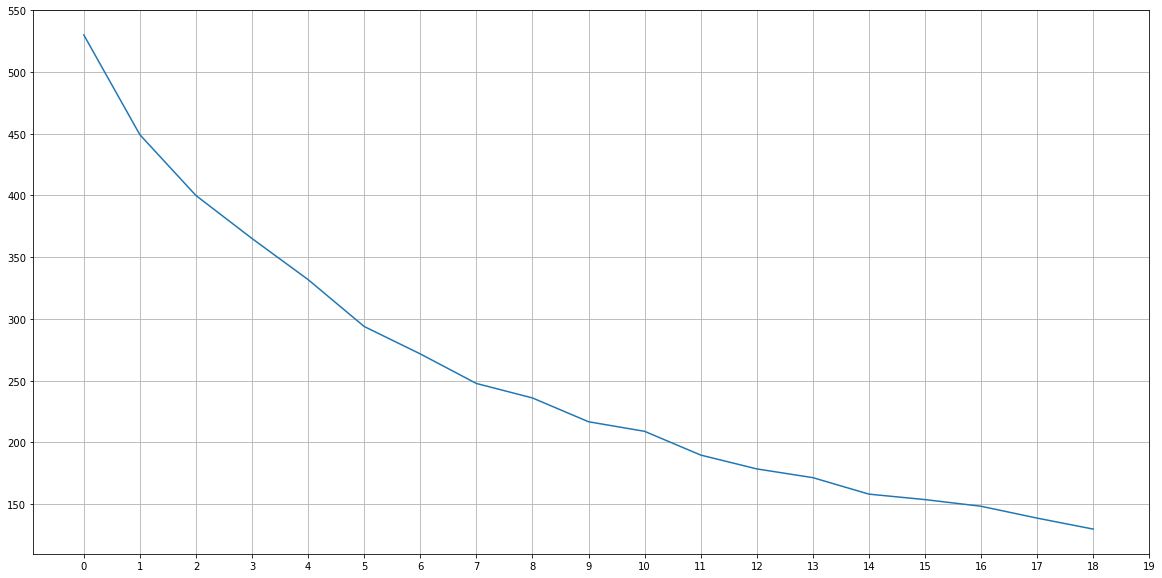

In [604]:
plt.figure(figsize = (20,10))
plt.plot(kmeans_list)
plt.xticks(ticks=(np.arange(20)))
plt.grid()
plt.savefig("elbow.jpg")

In [500]:
t = 0

if "child_df" in globals():
    del child_df
if "master_df" in globals():
    del master_df


for postal, lat, lng in zip(toronto_df['postal_code'][:2], toronto_df['latitude'][:2], toronto_df['longitude'][:2]):
    venue_id = []
    venue_name = []
    venue_categories = []
    venue_latlng = []
    venue_address = []
    venue_distance = []
    for cat in categories_df['categoryids']:
        venues = get_venues(client_id, client_secret, version, lat, lng, cat, 6000, 3)
        venue_id = venue_id + [venues[0]]
        venue_name = venue_name + [venues[1]]
        venue_categories = venue_categories + [venues[2]]
        venue_latlng = venue_latlng + [venues[3]]
        venue_address = venue_address + [venues[4]]
        venue_distance = venue_distance + [venues[5]]
            
    num = toronto_df.index[toronto_df['postal_code'] == postal].values[0]
    
    postal_loop = loop_toronto.loc[loop_toronto['postal_code'] == loop_toronto['postal_code'][num]].T

    if num != 0:
        child_df = postal_loop.append(pd.DataFrame([[venue_categories[0][0], venue_distance[0]],\
                  [venue_categories[1][0][0], venue_distance[1]],\
                  [venue_categories[2][0][0], venue_distance[2]],\
                  [venue_categories[3][0][0], venue_distance[3]],\
                  [venue_categories[4][0][0], venue_distance[4]],\
                  [venue_categories[5][0][0], venue_distance[5]],\
                  [venue_categories[6][0][0], venue_distance[6]],], index = ["metro_station",\
                                                                      "train_station",\
                                                                     " bus_station",\
                                                                      "bus_stop",\
                                                                      "shopping_mall",\
                                                                      "shopping_plaza",\
                                                                      "grocery_store"]))
    else:
           master_df = postal_loop.append(pd.DataFrame([[venue_categories[0][0], venue_distance[0]],\
                  [venue_categories[1][0][0], venue_distance[1]],\
                  [venue_categories[2][0][0], venue_distance[2]],\
                  [venue_categories[3][0][0], venue_distance[3]],\
                  [venue_categories[4][0][0], venue_distance[4]],\
                  [venue_categories[5][0][0], venue_distance[5]],\
                  [venue_categories[6][0][0], venue_distance[6]],], index = ["metro_station",\
                                                                      "train_station",\
                                                                     " bus_station",\
                                                                      "bus_stop",\
                                                                      "shopping_mall",\
                                                                      "shopping_plaza",\
                                                                      "grocery_store"]))



    try:
        master_df = pd.concat([master_df, child_df], axis=1)
        print("onto the next ones")
    except:
        print("first one finished")


first one finished
onto the next ones
